## Class Activation Map

 

In [1]:
## library import
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

print(tf.__version__)
print(keras.__version__)

/home/bit204/anaconda3/envs/python366/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bit204/anaconda3/envs/python366/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bit204/anaconda3/envs/python366/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bit204/anaconda3/envs/python366

2.0.0-beta1
2.2.4-tf


In [2]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions

In [3]:
img_size = 299

In [4]:
## pretrained mobilenet load
from keras.models import model_from_json 
json_file = open("./modeldata/model.json", "r")
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(n)
loaded_model.load_weiloaded_model_jsoghts("./modeldata/model.h5") 
print("Loaded model from disk")
loaded_model.summary()


NameError: name 'n' is not defined

In [4]:
'''mobilenet.trainable = False
modell = tf.keras.Sequential()
modell.add(loaded_model)
modell.add(tf.keras.layers.Flatten())
modell.add(tf.keras.layers.Dense(256, activation='relu'))
modell.add(tf.keras.layers.Dense(3, activation='sigmoid'))
modell.summary()'''
mobilenet = InceptionResNetV2(weights='conv.h5',include_top=True,
                     input_shape=(img_size, img_size, 3),classes=3)
mobilenet.summary()


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [1955]:
## input image를 받아서, 마지막 feature map을 출력해주는 model 생성
target_fmap = mobilenet.get_layer(name='activation_134').output
model = keras.models.Model(mobilenet.input, target_fmap)

In [1956]:
## fully connected layer의 weight
weights = mobilenet.get_layer(name='predictions').get_weights()[0]
print(weights.shape)

(1536, 3)


In [1957]:
## weight reshape
weights = np.reshape(weights, (128,-1))
print(weights.shape)

(128, 36)


In [1958]:
## test image를 읽어와서 224, 224로 resize
from PIL import Image

cur_dir = os.getcwd()
img_path = os.path.join(cur_dir, '/home/bit204/Desktop/mykeras/datasets/train/old', 'old_9695_.jpg')
currimg = Image.open(img_path)
currimg = currimg.resize((img_size, img_size))
image = np.asarray(currimg)
image = np.reshape(image, (-1, img_size, img_size, 3))
print(image.shape)

(1, 299, 299, 3)


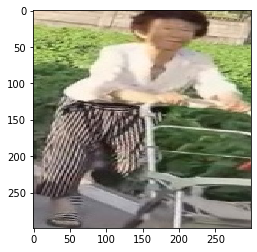

In [1959]:
## 화면에 출력
plt.imshow(image[0])
plt.show()

In [1960]:
## test image를 pretrained model에 넣고 feature map을 뽑음
fmap = model(preprocess_input(image))
fmap = np.reshape(np.array(fmap), (17,17,-1))
print(fmap.shape)

(17, 17, 160)


In [1961]:
## test image에 대한 top-1 class 확인
prediction = mobilenet.predict(preprocess_input(image))

pred_class = np.argmax(prediction, -1)
pred_class

array([2])

In [1962]:
## top-1 외에 다른 class에 대한 label에 대해서도 CAM을 수행할 수 있도록 label list 생성
label_list = np.argsort(prediction, -1)
label_list = label_list[0, ::-1]
label_list[0]

2

In [1963]:
## top-5 확인
decode_predictions(prediction)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 3)

In [1964]:
## top-5 class중 원하는 class에 대한 weight 가져오기
## 예) top-1 class: label_list[0], top-2 class: label_list[1], ...
#weights_cam = weights[:, pred_class[0]]
weights_cam = weights[:, label_list[2]]
print((weights_cam[1]))
print(label_list[2])

0.032058522
1


In [1965]:
## CAM 만들기 (0으로 초기화한 후 weight x feature map을 누적해서 더함)
camsum = np.zeros((17,17))
for i in range(32):
    camsum = camsum + weights_cam[i]*fmap[:,:,i]
camsum = camsum/1024.


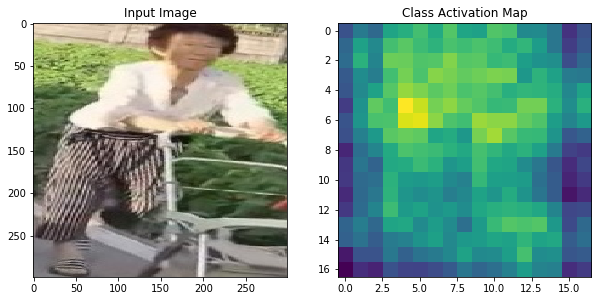

In [1966]:
## 원본 image와 CAM 확인
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(image[0])
ax1.set_title("Input Image")
ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(camsum)
ax2.set_title("Class Activation Map")
plt.show()

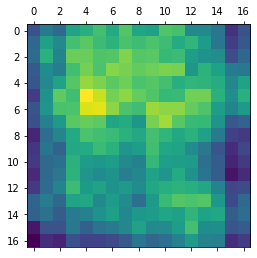

In [1967]:
## CAM을 0~1사이로 scaling
camsum /= camsum.max()
plt.matshow(camsum)
plt.show()

### CAM을 image로 저장

In [1968]:
!pip install opencv-python
import cv2

In [1969]:
img = cv2.imread(img_path)
img = cv2.resize(img, (img_size, img_size))
camsum = cv2.resize(camsum, (img_size, img_size))
heatmap = np.uint8(255*camsum)

In [1970]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [1971]:
## 원본 image와 CAM을 어느정도 비율로 섞을지 결정
superimposed_img = heatmap * 0.5 + img * 0.7

In [1972]:
## file 저장할 경로
cam_path = os.path.join(cur_dir, 'old2.jpg')

In [1973]:
## file 저장
cv2.imwrite(cam_path, superimposed_img)

True

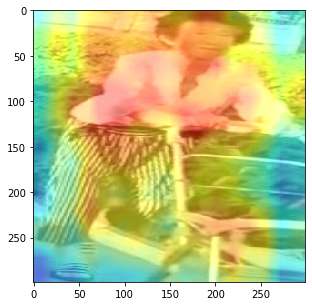

In [1974]:
currimg = Image.open(cam_path)
image = np.asarray(currimg)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()